In [1]:
%env DDE_BACKEND=tensorflow
import deepxde as dde
import numpy as np
import gc
import matplotlib.pyplot as plt
SEED=0xdde

env: DDE_BACKEND=tensorflow


2023-11-26 16:47:44.510354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 16:47:44.537537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 16:47:44.537570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 16:47:44.537591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 16:47:44.542496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 16:47:44.543182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def f1(x):
    return x * np.sin(5 * x)

# First establish the models

Set the default float type to float16
Compiling model...
'compile' took 0.002710 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.05e-01]    [3.54e-01]    [1.30e+00]    


/home/jacob/dev/lu-group/mixed-precision-sciml/.direnv/python-3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1000      [2.68e-02]    [2.85e-02]    [3.69e-01]    
2000      [3.31e-03]    [2.94e-03]    [1.19e-01]    
3000      [2.18e-03]    [1.86e-03]    [9.44e-02]    
4000      [1.89e-03]    [1.57e-03]    [8.67e-02]    
5000      [1.67e-03]    [1.36e-03]    [8.06e-02]    
6000      [1.59e-03]    [1.30e-03]    [7.90e-02]    
7000      [1.56e-03]    [1.27e-03]    [7.79e-02]    
8000      [1.52e-03]    [1.23e-03]    [7.67e-02]    
9000      [1.50e-03]    [1.31e-03]    [7.92e-02]    
10000     [1.48e-03]    [1.29e-03]    [7.87e-02]    

Best model at step 10000:
  train loss: 1.48e-03
  test loss: 1.29e-03
  test metric: [7.87e-02]

'train' took 11.077940 s



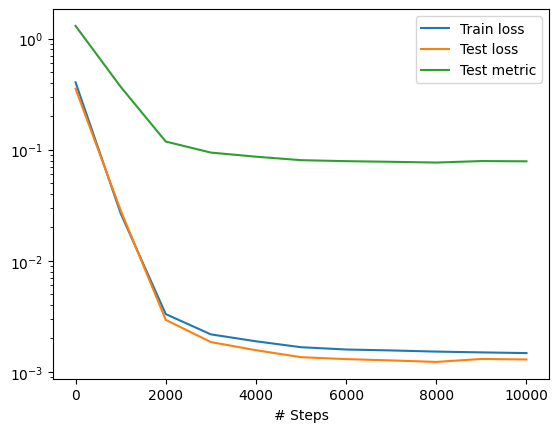

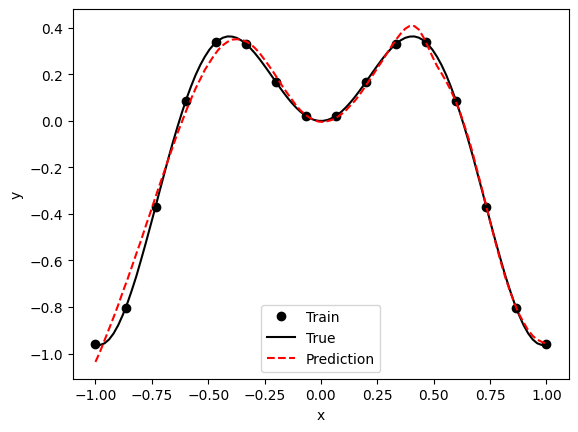

In [3]:
dde.config.set_random_seed(SEED)
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [10] * 2 + [1], activation, initializer)
model16 = dde.Model(data, net)
model16.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model16.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)


Set the default float type to float32
Compiling model...
'compile' took 0.004530 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    
1000      [3.19e-02]    [3.39e-02]    [4.03e-01]    
2000      [2.43e-04]    [2.43e-04]    [3.41e-02]    
3000      [1.19e-04]    [1.49e-04]    [2.67e-02]    
4000      [8.85e-05]    [1.25e-04]    [2.44e-02]    
5000      [7.70e-05]    [1.13e-04]    [2.33e-02]    
6000      [6.54e-05]    [1.00e-04]    [2.19e-02]    
7000      [5.30e-05]    [8.62e-05]    [2.03e-02]    
8000      [4.12e-05]    [7.27e-05]    [1.87e-02]    
9000      [3.16e-05]    [6.00e-05]    [1.69e-02]    
10000     [3.72e-05]    [6.83e-05]    [1.81e-02]    

Best model at step 9000:
  train loss: 3.16e-05
  test loss: 6.00e-05
  test metric: [1.69e-02]

'train' took 10.617351 s



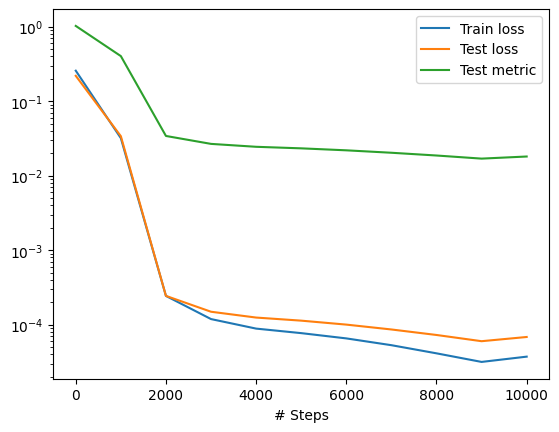

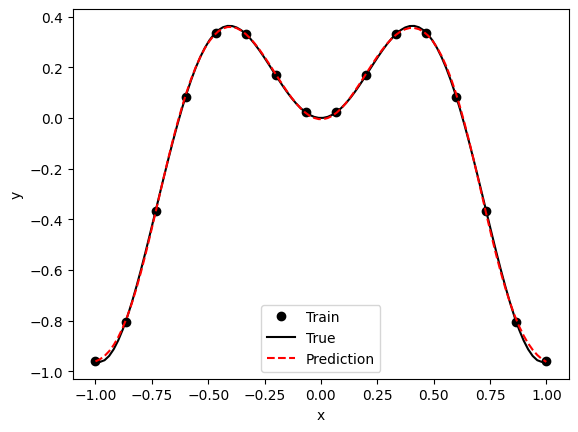

In [4]:
dde.config.set_random_seed(SEED)
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [10] * 2 + [1], activation, initializer)
model32 = dde.Model(data, net)
model32.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model32.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# Plot The Loss Landscapes
Using https://github.com/artur-deluca/landscapeviz because it supports tensorflow 2.

# Now try to make a 16 bit FNN with the same weights as a 32 bit FNN (just truncated)
Having a determinstic random seed is not enough; we need the weights (and the loss landscape) to start the same so that we can see how (any why) they diverge.

Set the default float type to float32
Compiling model...
'compile' took 0.003567 s



Set the default float type to float16
Compiling model...
'compile' took 0.002403 s



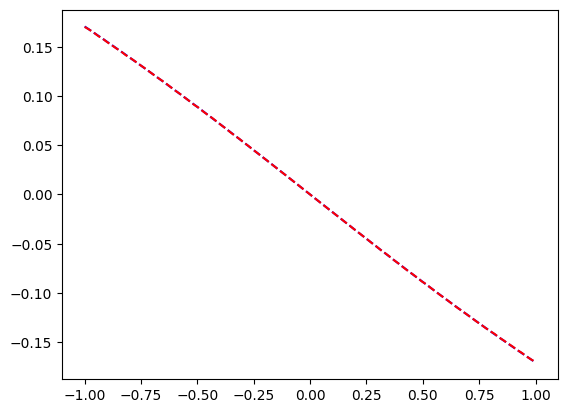

In [5]:
import deepxde as dde
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
dde.config.set_random_seed(SEED)
#
# Create the original model as float32
#
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model32_to_copy = dde.Model(data, net)
model32_to_copy.compile("adam", lr=0.001, metrics=["l2 relative error"])
# print the original weights
# generate the test arrays
_ = model32_to_copy.data.test()
# do one evaluation to initialize the weights
_ = model32_to_copy.predict([[1]])


#
# create a new model, but float16
#
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model16_new = dde.Model(data, net)
model16_new.compile("adam", lr=0.001, metrics=["l2 relative error"])

# generate the test arrays
_ = model16_new.data.test()
# do one evaluation to initialize the weights
_ = model16_new.predict([[1]])
# copy the weights
for i, layer in enumerate(model32_to_copy.net.denses):
    model16_new.net.denses[i].set_weights([tf.cast(w, dtype=tf.float16) for w in layer.get_weights()])
# make sure it worked by plotting the function with no training; should be the same as the first plot; they should overlap perfectly
plt.plot(model32_to_copy.data.test_x, model32_to_copy.predict(model32_to_copy.data.test_x), 'b--')
plt.plot(model16_new.data.test_x, model16_new.predict(model16_new.data.test_x), 'r--')
plt.show()
class SaveLosslandscapeCallback(dde.callbacks.Callback):
    def __init__(self, name, resolution=20, period=700, total_epochs=0):
        super().__init__()
        self.name = name
        self.period = period
        self.epochs_since_last_save = 0
        self.total_epochs = total_epochs
        self.resolution = resolution
    def on_epoch_begin(self):
        self.total_epochs += 1
        self.epochs_since_last_save += 1
        # since a lot of the gradient descent happens in the first 100 epochs, capture that
        if self.epochs_since_last_save < self.period and self.total_epochs not in range(0,100,5) and self.total_epochs not in range(0,5):
            return
        self.epochs_since_last_save = 0
        from deepxde import losses
        mse = losses.get("MSE")
        self.model.net.compile(loss=mse)
        self.model.net.loss = "MSE"
        print(f'\nGENERATING mesh after epoch {self.total_epochs}...; saving to ./files/{self.name}_epoch_{self.total_epochs}.hdf5\n')
        build_mesh(
            self.model.net,(self.model.data.train_x,self.model.data.train_y),
            grid_length=self.resolution,seed=SEED,verbose=False,extension=1,
            filename=f"{self.name}_epoch_{self.total_epochs}",
            predicted=(self.model.data.test_x, self.model.predict(self.model.data.test_x))
        )
        gc.collect()

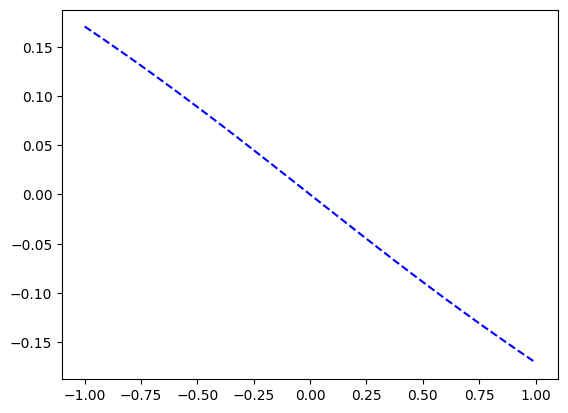

Set the default float type to float32
Training model...

Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    
1000      [3.19e-02]    [3.39e-02]    [4.03e-01]    
2000      [2.43e-04]    [2.43e-04]    [3.41e-02]    
3000      [1.19e-04]    [1.49e-04]    [2.67e-02]    
4000      [8.85e-05]    [1.25e-04]    [2.44e-02]    
5000      [7.70e-05]    [1.13e-04]    [2.33e-02]    
6000      [6.54e-05]    [1.00e-04]    [2.19e-02]    
7000      [5.30e-05]    [8.62e-05]    [2.03e-02]    
8000      [4.12e-05]    [7.27e-05]    [1.87e-02]    
9000      [3.16e-05]    [6.00e-05]    [1.69e-02]    
10000     [3.72e-05]    [6.83e-05]    [1.81e-02]    

Best model at step 9000:
  train loss: 3.16e-05
  test loss: 6.00e-05
  test metric: [1.69e-02]

'train' took 10.756952 s



In [6]:
plt.plot(model32_to_copy.data.test_x, model32_to_copy.predict(model32_to_copy.data.test_x), 'b--')
plt.show()

dde.config.set_default_float('float32')
model32_to_copycallbacks = [SaveLosslandscapeCallback(name="model32_to_copy", period=20)]
model32_to_copycallbacks = []
# model32_to_copycallbacks = []
losshistory, train_state = model32_to_copy.train(iterations=10_000, callbacks=model32_to_copycallbacks,display_every=1000)

Set the default float type to float16


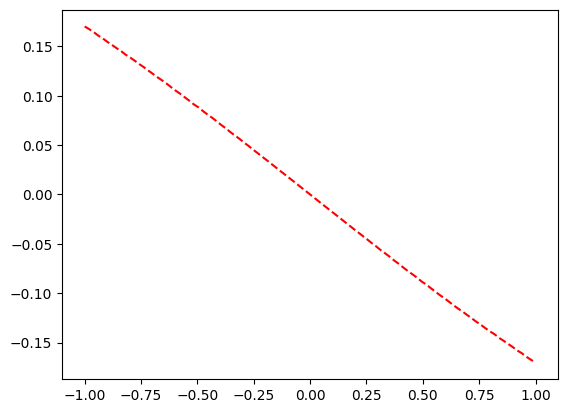

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    
1000      [7.72e-03]    [8.78e-03]    [2.05e-01]    
2000      [5.42e-03]    [5.58e-03]    [1.64e-01]    
3000      [2.84e-03]    [3.40e-03]    [1.28e-01]    
4000      [1.31e-03]    [1.61e-03]    [8.79e-02]    
5000      [8.90e-04]    [1.25e-03]    [7.75e-02]    
6000      [8.76e-04]    [1.24e-03]    [7.70e-02]    
7000      [7.93e-04]    [1.18e-03]    [7.52e-02]    
8000      [7.31e-04]    [1.13e-03]    [7.34e-02]    
9000      [6.97e-04]    [1.11e-03]    [7.30e-02]    
10000     [6.82e-04]    [1.08e-03]    [7.19e-02]    

Best model at step 10000:
  train loss: 6.82e-04
  test loss: 1.08e-03
  test metric: [7.19e-02]

'train' took 11.032930 s



In [7]:
dde.config.set_default_float('float16')

plt.plot(model16_new.data.test_x, model16_new.predict(model16_new.data.test_x), 'r--')
plt.show()

model16_newcallbacks = [SaveLosslandscapeCallback(name="model16_new", period=20)]
model16_newcallbacks = []
losshistory, train_state = model16_new.train(iterations=10_000, callbacks=model16_newcallbacks,display_every=1000)

# Data analysis to display the results

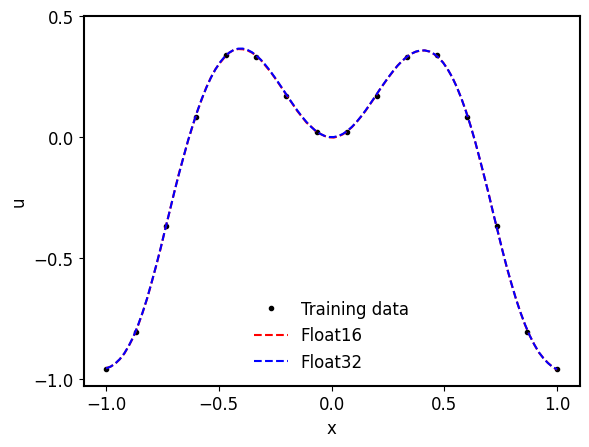

In [14]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['font.size'] = 12

for i, layer in enumerate(model32.net.denses):
    model16.net.denses[i].set_weights([tf.cast(w, dtype=tf.float16) for w in layer.get_weights()])

plt.plot(model16.data.train_x, f1(model16.data.train_x), 'k.', label="Training data", linewidth=1.5)
plt.plot(space, model16.predict(space), 'r--', label="Float16", linewidth=1.5)
plt.plot(space, model32.predict(space), 'b--', label="Float32", linewidth=1.5)
plt.legend(frameon=False)
plt.xlabel('x')
plt.xticks([-1, -.5, 0, .5, 1])
plt.yticks([-1, -.5, 0, .5])
plt.ylabel('u')

# Set the linewidth of the figure border to 1.5
for axis in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[axis].set_linewidth(1.5)

plt.savefig("casting_weights.pdf")
plt.show()